In [1]:
import numpy as np
from numpy import sqrt, sin, cos
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.special import jv as j
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 150
from scipy.stats import linregress

In [2]:
def grid_norm(v, h, n):
    if n is 1:
        return h*np.sum(np.abs(v))
    elif n is 2:
        return np.sqrt(h*np.sum(np.power(np.abs(v), 2)))
    elif n is 'inf':
        return np.max(np.abs(v))

In [3]:
def Uxx_Uyy_stencil(n, s):
    #9-point stencil
    if s == 9:
        A = (1/6)*sp.diags([4,-20,4], [-1,0,1], shape=(n,n))
        I = (1/6)*sp.diags([1,4,1], [-1,0,1], shape=(n,n))
    
    #9-point stencil
    if s == 5:
        A = sp.diags([1,-4,1], [-1,0,1], shape=(n,n))
        I = sp.diags([0,1,0], [-1,0,1], shape=(n,n))
        
    Z = sp.csr_matrix(np.zeros((n,n)))
    block = [Z]*n + [I,A,I] + [Z]*n
    blocks = [block[n+1-i:2*n+1-i] for i in range(n)]
    
    return sp.bmat(blocks)

In [4]:
def Uxxyy_stencil(n):
    #9-point
    A = (1/6)*sp.diags([-2,4,-2], [-1,0,1], shape=(n,n))
    I = (1/6)*sp.diags([1,-2,1], [-1,0,1], shape=(n,n))
        
    Z = sp.csr_matrix(np.zeros((n,n)))
    block = [Z]*n + [I,A,I] + [Z]*n
    blocks = [block[n+1-i:2*n+1-i] for i in range(n)]
    
    return sp.bmat(blocks)

In [5]:
def Helmholtz(n, k, s, correction):
    """
    non-homogeneous Helmholtz equation
    U_xx + U_yy + k^2 U = f(x,y)
    D = [0,1]x[0,1]
    """
    
    #intialize constants
    h = 1 / n
    X = np.linspace(0, 1, n+1)
    xv, yv = np.meshgrid(X, X)
    
    #forcing function
    f = lambda x, y: (k**2 - 1)*(cos(x) + sin(y))
    d2f = lambda x, y: (1 - k**2)*(cos(x) + sin(y))
    
    #boundry condition function
    bc_func = lambda x, y: j(0, k*sqrt(x**2 + y**2)) + cos(x) + sin(y)
    
    #make A matrix
    N = (n-1)**2
    A = Uxx_Uyy_stencil(n-1, s)/h**2
    A += sp.diags([k**2], shape=A.shape)
    
    #boundry conditons
    bc = np.zeros((n-1, n-1))
    bc[:, 0] += bc_func(0, X[1:-1])
    bc[:, -1] += bc_func(1, X[1:-1])
    bc[0] += bc_func(X[1:-1], 0)
    bc[-1] += bc_func(X[1:-1], 1)
    bc = bc.flatten() / h**2
    
    #solve for f
    F = f(xv[1:-1, 1:-1], yv[1:-1, 1:-1])
    F = F.flatten()
    #deferred correction
    if correction:
        U = spla.spsolve(A, F - bc)
        if s == 5:
            def_cor = h**2 / 12 * (d2f(xv[1:-1, 1:-1], yv[1:-1, 1:-1]).flatten()
                                   - k**2*F + k**4*U
                                   - 2*Uxxyy_stencil(n-1)@U/h**4)
        if s == 9:
            def_cor = h**2 / 12 * (d2f(xv[1:-1, 1:-1], yv[1:-1, 1:-1]).flatten()
                                   - k**2*F + k**4*U)
        F += def_cor
    
    #solve for U
    U = bc_func(xv, yv)
    U_in = spla.spsolve(A, F - bc)
    U_in = U_in.reshape(n-1, n-1)
    U[1:-1, 1:-1] = U_in
    
    return U

In [6]:
true_f = lambda x, y, k: j(0, k*sqrt(x**2 + y**2)) + cos(x) + sin(y)

In [7]:
k, n = 20, 100

#solve
U5 = Helmholtz(n, k, 5, False)
U5dc = Helmholtz(n, k, 5, True)
U9 = Helmholtz(n, k, 9, False)
U9dc = Helmholtz(n, k, 9, True)
X = np.linspace(0, 1, n+1)
xv, yv = np.meshgrid(X, X)
sol = true_f(xv, yv, k)

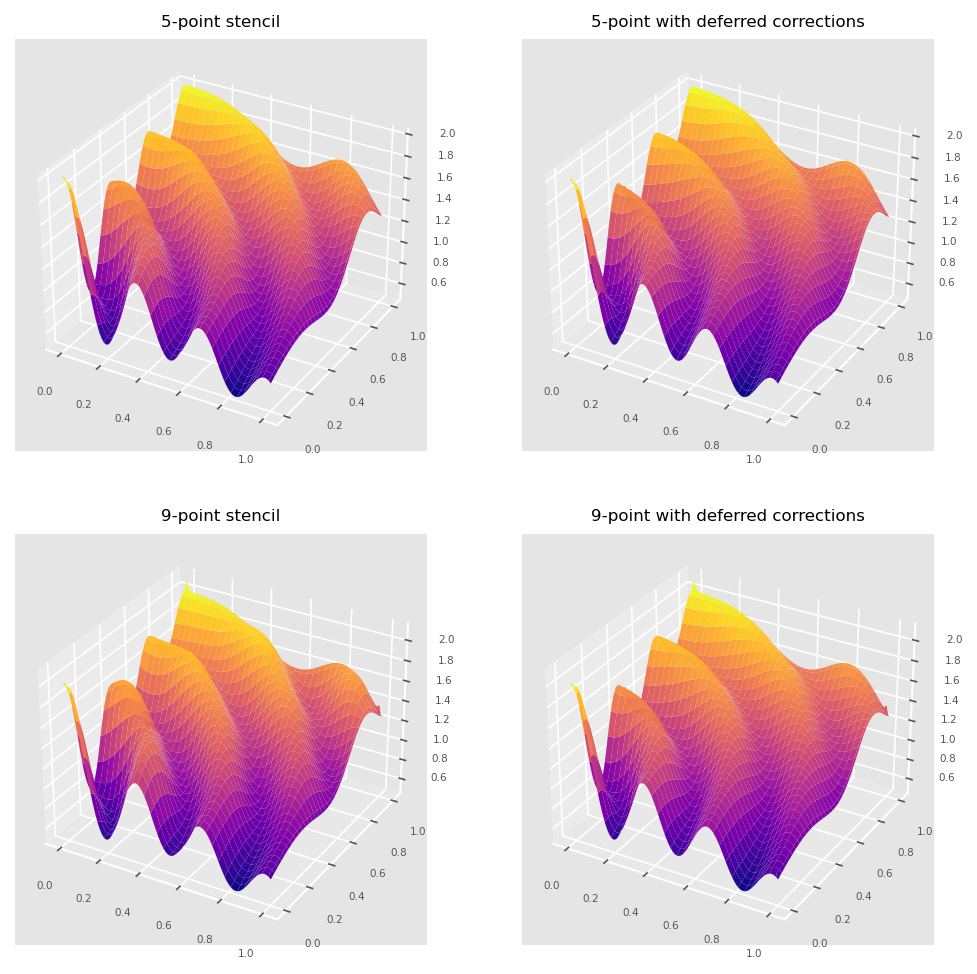

In [8]:
#plot
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.set_title('5-point stencil', size=8)
ax.plot_surface(xv, yv, U5, cmap='plasma')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
ax.tick_params(axis='z', labelsize=5)

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.set_title('5-point with deferred corrections', size=8)
ax.plot_surface(xv, yv, U5dc, cmap='plasma')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
ax.tick_params(axis='z', labelsize=5)

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_title('9-point stencil', size=8)
ax.plot_surface(xv, yv, U9, cmap='plasma')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
ax.tick_params(axis='z', labelsize=5)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.set_title('9-point with deferred corrections', size=8)
ax.plot_surface(xv, yv, U9dc, cmap='plasma')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
ax.tick_params(axis='z', labelsize=5)

plt.show()

In [9]:
k = 20
N = np.array([100, 200, 300, 400, 500])
error_5 = []
error_5dc = []
error_9 = []
error_9dc = []

for n in N:
    #solve
    U5 = Helmholtz(n, k, 5, False)
    U5dc = Helmholtz(n, k, 5, True)
    U9 = Helmholtz(n, k, 9, False)
    U9dc = Helmholtz(n, k, 9, True)
    X = np.linspace(0, 1, n+1)
    xv, yv = np.meshgrid(X, X)
    sol = true_f(xv, yv, k)
    
    #error
    error_5.append(grid_norm(U5 - sol, 1/(n+1)**2, 'inf'))
    error_5dc.append(grid_norm(U5dc - sol, 1/(n+1)**2, 'inf'))
    error_9.append(grid_norm(U9 - sol, 1/(n+1)**2, 'inf'))
    error_9dc.append(grid_norm(U9dc - sol, 1/(n+1)**2, 'inf'))

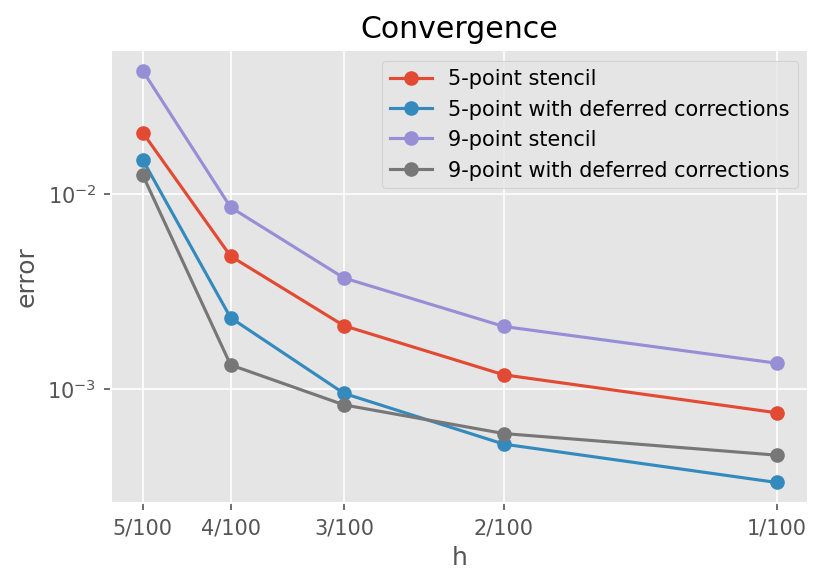

In [10]:
#plot
plt.title('Convergence')
H = 1/N
plt.loglog(H[::-1], error_5, '-o', label='5-point stencil')
plt.loglog(H[::-1], error_5dc, '-o', label='5-point with deferred corrections')
plt.loglog(H[::-1], error_9, '-o', label='9-point stencil')
plt.loglog(H[::-1], error_9dc, '-o', label='9-point with deferred corrections')
plt.ylabel('error')
plt.xlabel('h')
plt.minorticks_off()
plt.xticks(H, ['1/100', '2/100', '3/100', '4/100', '5/100'])
plt.legend()
plt.show()

In [11]:
conv_order_5 = linregress(np.log(H), np.log(error_5))[0]
conv_order_5dc = linregress(np.log(H), np.log(error_5dc))[0]
conv_order_9 = linregress(np.log(H), np.log(error_9))[0]
conv_order_9dc = linregress(np.log(H), np.log(error_9dc))[0]

print(f'5-point convergence = O(h^{round(conv_order_5, 2)})')
print(f'5-point with deferred corrections convergence = O(h^{round(conv_order_5dc, 2)})')
print(f'9-point convergence = O(h^{round(conv_order_9, 2)})')
print(f'9-point with deferred corrections convergence = O(h^{round(conv_order_9dc, 2)})')

5-point convergence = O(h^2.05)
5-point with deferred corrections convergence = O(h^2.36)
9-point convergence = O(h^2.14)
9-point with deferred corrections convergence = O(h^2.01)
